In [1]:
import os
import sys
import mlflow
import time
import tensorflow
import contextlib

import pandas as pd
import seaborn as sns

from io import StringIO
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sys.path.append("../")

from models.scorer import home_credit_loss_fn_keras
from scripts.mlflow_functions import train_and_log_keras

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
tensorflow.get_logger().setLevel("ERROR")


In [2]:
try:
    mlflow.create_experiment(name="home_credit_model")
except mlflow.MlflowException:
    mlflow.set_experiment(experiment_name="home_credit_model")


In [3]:
df_model = pd.read_pickle(filepath_or_buffer="../data/df_hc_nm_imputed.pkl")


# Light preprocessing

In [4]:
# we need to redefine binary cols as variables that use 0, 1 or -1 (sentinel) :

def detect_binary_cols_with_sentinel(dataframe: pd.DataFrame):
    """
    Detects binary columns in a pandas dataframe.

    Args:
    - df: pandas dataframe.

    Returns:
    - list of binary column names.
    """

    binary_cols = []

    for col in dataframe.columns:
        unique_vals = dataframe[col].dropna().unique()
        if len(unique_vals) == 2 and set(unique_vals) == {0, 1}:
            binary_cols.append(col)

    return binary_cols


## Identifying the binary cols (0 , 1, -1 (sentinel)) : not to scale

In [5]:
binary_cols = detect_binary_cols_with_sentinel(dataframe=df_model)


In [6]:
numeric_to_scale = [col for col in df_model.columns if col not in binary_cols]


## Scaling the numeric columns for Keras

In [7]:
scaler = StandardScaler()


In [8]:
scaler = StandardScaler()
df_model[numeric_to_scale] = scaler.fit_transform(df_model[numeric_to_scale])


In [9]:
df_model.head()

df_model.to_pickle(path="../data/df_hc_nm_imputed_scaled.pkl")


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df_model.drop(columns=["TARGET"]),
    df_model["TARGET"],
    test_size=0.3,
    random_state=123,
    stratify=df_model["TARGET"]
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=123,
    stratify=y_train
    )


# DNN : 

- input of size feature len
- 512 dense
- dropout 30%
- 256 dense
- dropout 20%
- Sigmoid for binary clf
- Validation set to track overfitting


## Create the DNN

In [11]:
recall = tensorflow.keras.metrics.Recall()

# Input layer
inputs = tensorflow.keras.Input(shape=(X_train.shape[1],))

# Hidden layers
dense_1 = tensorflow.keras.layers.Dense(512, activation="relu")(inputs)
dropout_30 = tensorflow.keras.layers.Dropout(0.3)(dense_1)
dense_2 = tensorflow.keras.layers.Dense(256, activation="relu")(dropout_30)
dropout_20 = tensorflow.keras.layers.Dropout(0.2)(dense_2)

# Output layer
outputs = tensorflow.keras.layers.Dense(1, activation="sigmoid")(dropout_20)

model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="adam", loss=home_credit_loss_fn_keras, metrics=[recall])


In [12]:
model_summary = model.summary()

summary_buffer = StringIO()

with contextlib.redirect_stdout(summary_buffer):
    model.summary()

model_summary = summary_buffer.getvalue()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 283)]             0         
                                                                 
 dense (Dense)               (None, 512)               145408    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 276,993
Trainable params: 276,993
Non-trainable

## Run the DNN

In [13]:
start = time.perf_counter()

history = model.fit(
    X_train,
    y_train,
    epochs=35,
    batch_size=64,
    validation_data=(X_val, y_val)
    )

end = time.perf_counter()

training_time = end - start

Epoch 1/35


2023-03-06 15:38:11.465533: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


407/407 [==============================] - 2s 4ms/step - loss: 5.9592 - recall: 0.7002 - val_loss: 4.8340 - val_recall: 0.8005
Epoch 2/35
407/407 [==============================] - 2s 4ms/step - loss: 5.8247 - recall: 0.7480 - val_loss: 5.5453 - val_recall: 0.7613
Epoch 3/35
407/407 [==============================] - 2s 4ms/step - loss: 5.7656 - recall: 0.7636 - val_loss: 5.6329 - val_recall: 0.7597
Epoch 4/35
407/407 [==============================] - 2s 4ms/step - loss: 5.7043 - recall: 0.7740 - val_loss: 5.3271 - val_recall: 0.7814
Epoch 5/35
407/407 [==============================] - 2s 4ms/step - loss: 5.6819 - recall: 0.7854 - val_loss: 5.0703 - val_recall: 0.7920
Epoch 6/35
407/407 [==============================] - 1s 4ms/step - loss: 5.6871 - recall: 0.7950 - val_loss: 5.6519 - val_recall: 0.7613
Epoch 7/35
407/407 [==============================] - 2s 4ms/step - loss: 5.7025 - recall: 0.8054 - val_loss: 5.4713 - val_recall: 0.7708
Epoch 8/35
407/407 [=========================

In [14]:
def get_best_model(history):
    """
    Returns the best Keras model based on validation loss from the training history.
    """
    val_loss = history.history["val_loss"]
    best_epoch = val_loss.index(min(val_loss))
    best_model = tensorflow.keras.models.clone_model(model)
    best_model.build(input_shape=X_train.shape[1:])
    best_model.compile(
        optimizer='adam',
        loss=home_credit_loss_fn_keras,
        metrics=[tensorflow.keras.metrics.Recall()]
        )
    best_model.set_weights(history.model.get_weights())
    return best_model, best_epoch


In [15]:
best_model, best_epoch = get_best_model(history=history)


In [16]:
best_score = best_model.evaluate(x=X_val, y=y_val)[0]


272/272 [==============================] - 0s 669us/step - loss: 6.4194 - recall_1: 0.7146


In [17]:
print(best_score)


6.419432163238525


In [18]:
print(f"Best model achieved after : {best_epoch} epochs")


Best model achieved after : 0 epochs


466/466 [==============================] - 0s 538us/step


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2023/03/06 15:46:14 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2023/03/06 15:46:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/3s/s8sp6jwn6qs02jfxbgjc7c_40000gn/T/tmpw1x9lxqg/model, flavor: tensorflow), fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to s

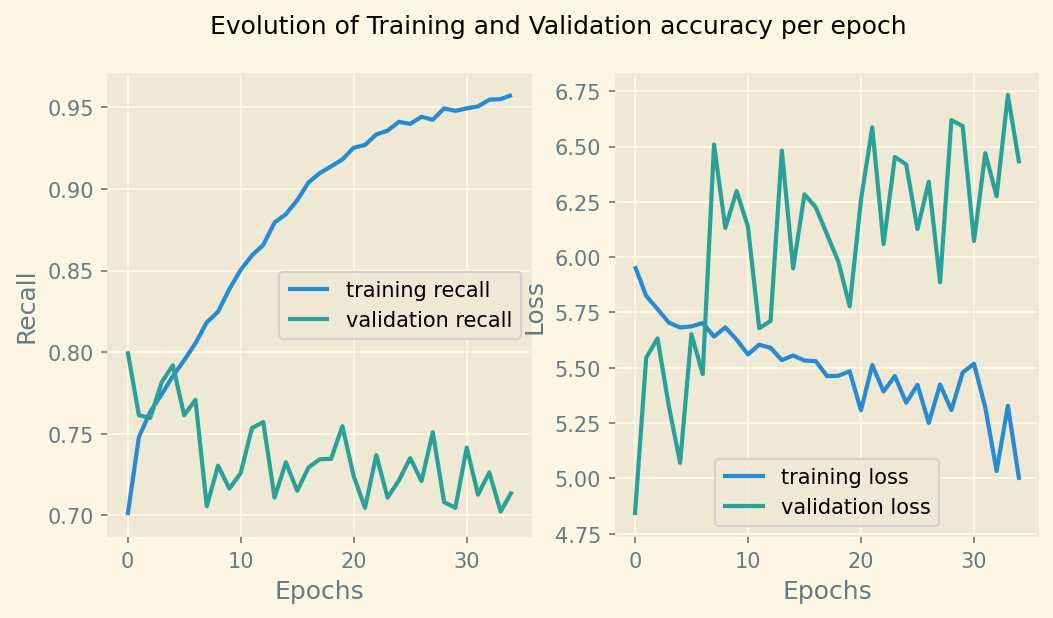

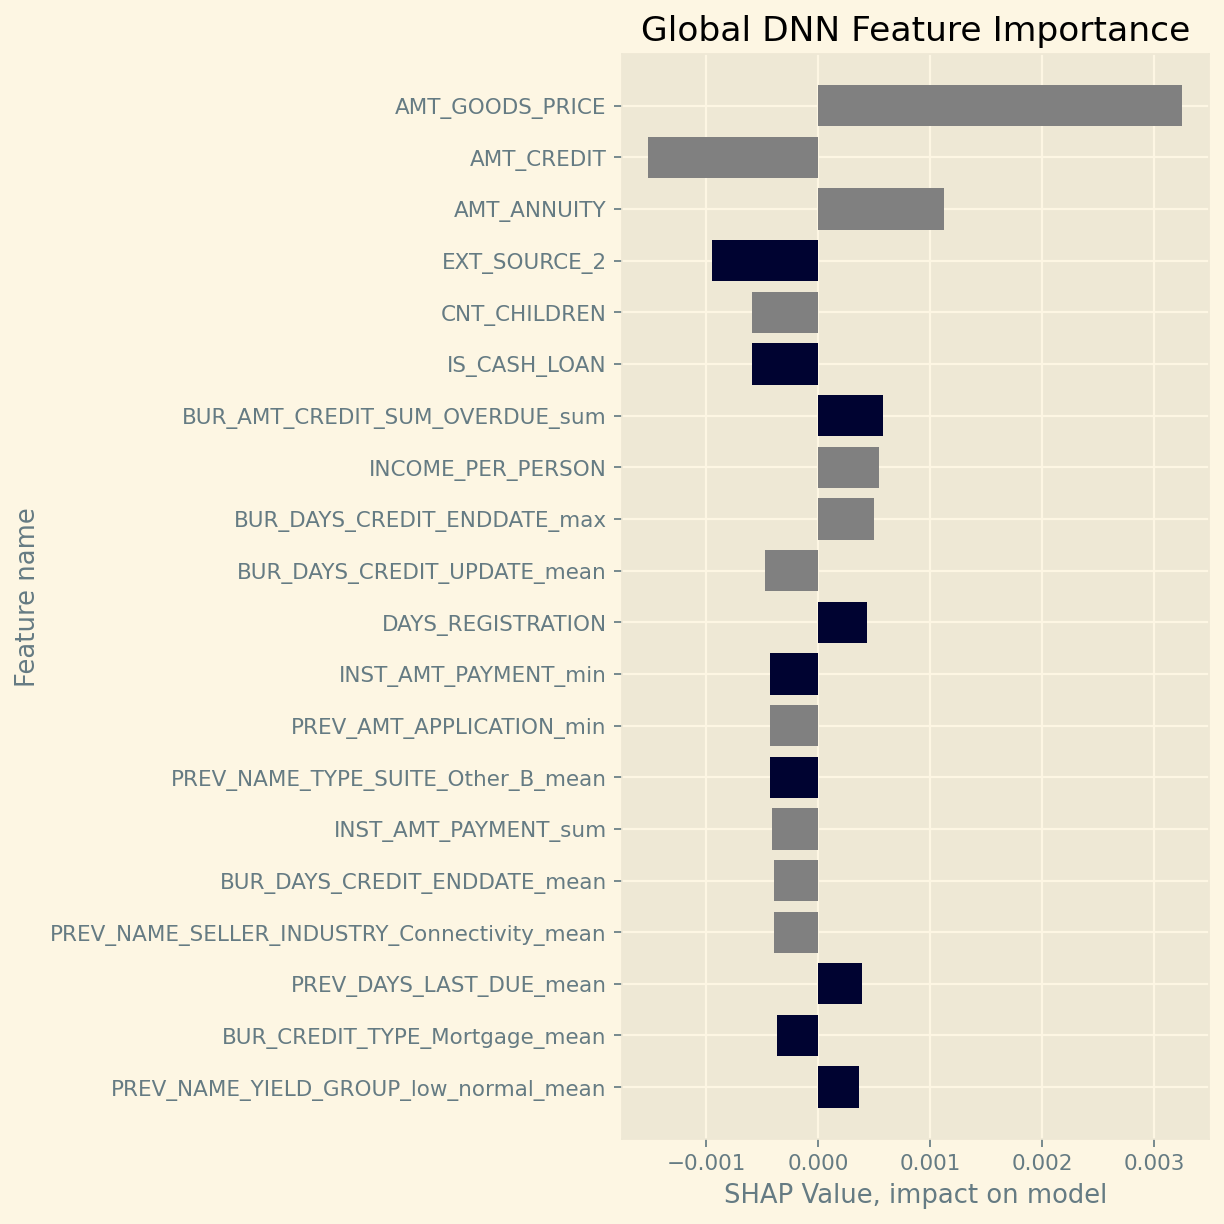

In [19]:
mlflow.set_experiment(experiment_name="home_credit_model")

metrics, model = train_and_log_keras(
    model=best_model,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    training_time=training_time,
    model_summary=model_summary,
    history=history,
    model_name="DNN_TEST",
    dataset_version="Nans_imputed",
    imb_method="nm1",
    home_credit_score=best_score,
    feature_list=X_train.columns.tolist()
)
